# TLDR

The contact distribution from positive cases is a biased representation of the underlying contact distribution of the population. (People with more contacts are more likely to become infected and contribute to the observed contact distribution, and vice versa.)

We would like to use Bayesian inference to obtain a more accurate underlying contact distribution. 

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive

import torch
import pandas as pd
import time

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def observe_contact_distribution(
        N: int, # population size
        lamda: float, # prevalence
        beta: float, # prob infection given contact with positive person
        concentration: torch.Tensor, # concentration of Dirichlet prior for p 
        data: torch.Tensor = None # observed data
    ):

    # contact distribution
    p = pyro.sample(
        'p', 
        dist.Dirichlet(concentration=concentration), 
    )
    binomial_counts = pyro.deterministic("binomial_counts", (N*p).int())
    
    p_inf = 1-(1-lamda*beta)**torch.arange(3)

    with pyro.plate('data'):
        obs = pyro.sample(
            'obs', 
            dist.Binomial(
                total_count=binomial_counts, 
                probs=p_inf),
            obs=data 
        )
    return obs

In [9]:
N=200 
lamda=0.05 
beta=0.1 
concentration=torch.Tensor([1,1,1]) 

# observed contact distribution, 
# i.e., 5 have 0, 5 have 1, 10 have 2 contacts
y=torch.tensor([5,5,10]) 


nuts_kernel = NUTS(observe_contact_distribution) # also called "sampler"
mcmc = MCMC(nuts_kernel, warmup_steps=100, num_samples=500)


In [10]:
start_time = time.time()
mcmc.run(N, lamda, beta, concentration, y)
print(f"Took {time.time()-start_time} seconds")

Sample: 100%|██████████| 600/600 [35:41,  3.57s/it, step size=7.49e-03, acc. prob=0.483]

Took 2141.3156826496124 seconds


In [11]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


In [27]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [12]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: p
       mean       std        5%       25%       50%       75%       95%
0  0.265131  0.090866  0.122062  0.202133  0.259273  0.320654  0.426147
1  0.264431  0.087584  0.135061  0.205940  0.258911  0.312895  0.411339
2  0.470438  0.104668  0.303161  0.403262  0.468654  0.538124  0.654683 



Text(0.5, 1.0, 'Posterior distribution of p')

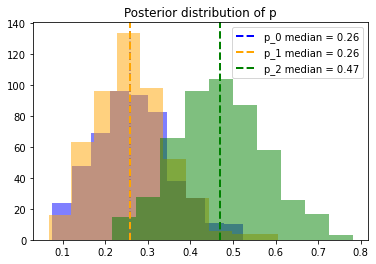

In [26]:

colors_dict = {0: "blue", 1: "orange", 2: "green"}

for i in range(3):
    plt.hist(hmc_samples['p'][:,i], alpha = 0.5, color=colors_dict[i])
    med = np.median(hmc_samples['p'][:,i])
    plt.axvline(
        med, 
        color = colors_dict[i], linestyle = 'dashed', linewidth = 2,
        label = f'p_{i} median = {med:.2f}'
        )

plt.legend()

plt.title("Posterior distribution of p")